# Prophet demo

Whole notebook is based on Prophet tutorial from following link:

https://facebook.github.io/prophet/docs/quick_start.html#python-api

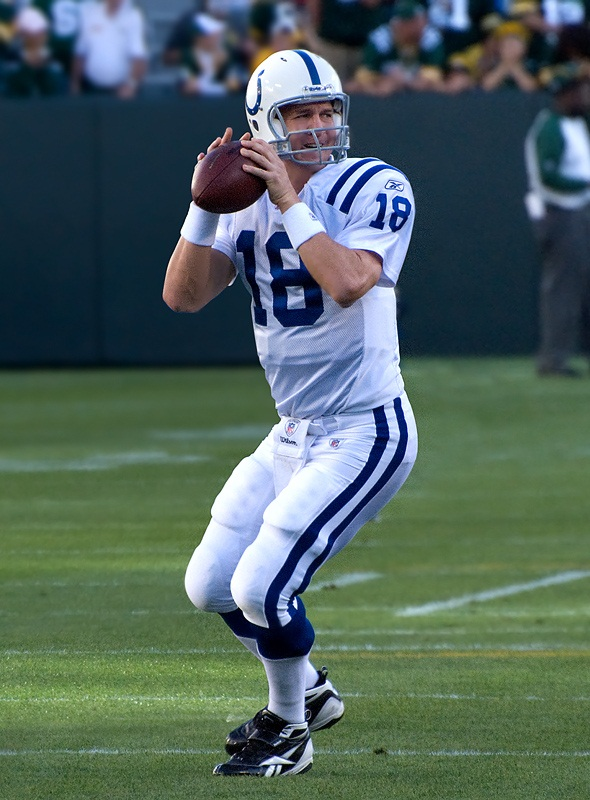

https://en.wikipedia.org/wiki/Peyton_Manning#/media/File:Peyton_Manning_passing.jpg

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly


The input to Prohet is two columns: `ds` and `y`. `ds` can be datestamp or timestamp and `y` is the numeric measurement we wish to forecast.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

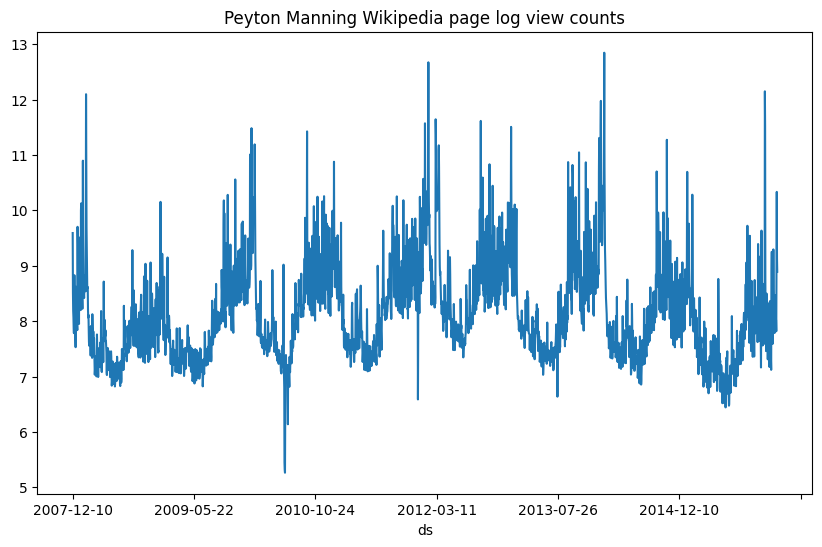

In [3]:
df.plot(x='ds', y='y', figsize=(10, 6), legend=False)
plt.title('Peyton Manning Wikipedia page log view counts')
plt.show()

Prophet is similar to `sklearn` model API. We have to create model instance and we have access to `fit` and `predict` methods.

In [4]:
m = Prophet()
m.fit(df)

10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing


Here we use available helper function and create dataframe containting dates for prediction

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

In [6]:
forecast = m.predict(future)

In [7]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.203190    7.425442    8.927358
3266 2017-01-16  8.528195    7.795120    9.275033
3267 2017-01-17  8.315591    7.589582    9.060019
3268 2017-01-18  8.148199    7.508457    8.866462
3269 2017-01-19  8.160106    7.423554    8.928069

In [9]:
plot_plotly(m, forecast)

In [10]:
plot_components_plotly(m, forecast)

## Trend changepoints

Prophet detects trend changepoints automatically.
It places potential 25 changepoints uniformly in first 80% of data.
We can adjust it with
```python
m = Prophet(
    changepoint_range=0.9,
    n_changepoints=100
)
```

https://facebook.github.io/prophet/docs/trend_changepoints.html

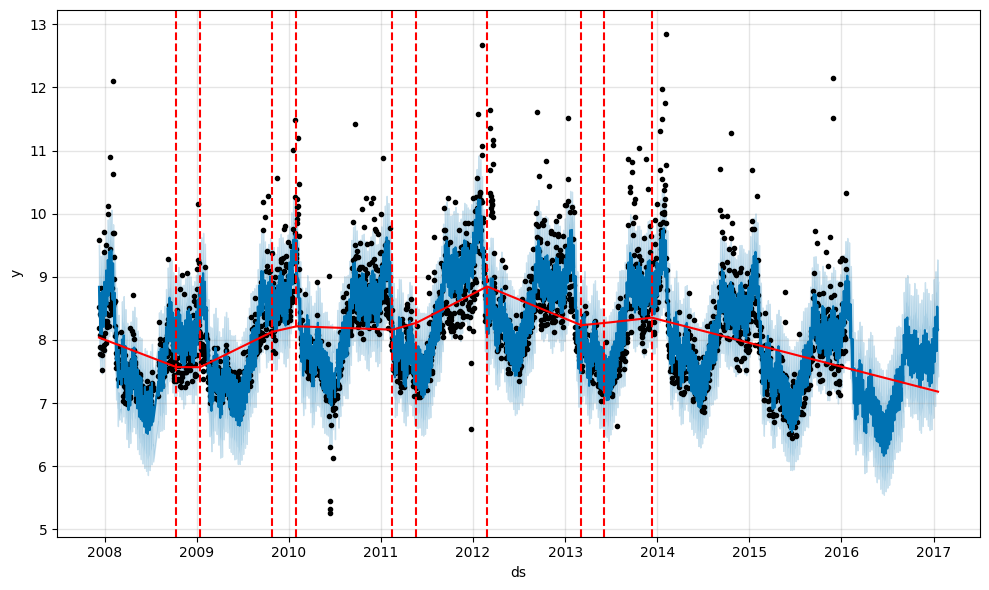

In [11]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

We can also manipualte with trend flexibility. We can prevent model from overfitting or fit it better to the data.
We do this by specifying parameter `changepoint_prior_scale`.

10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing


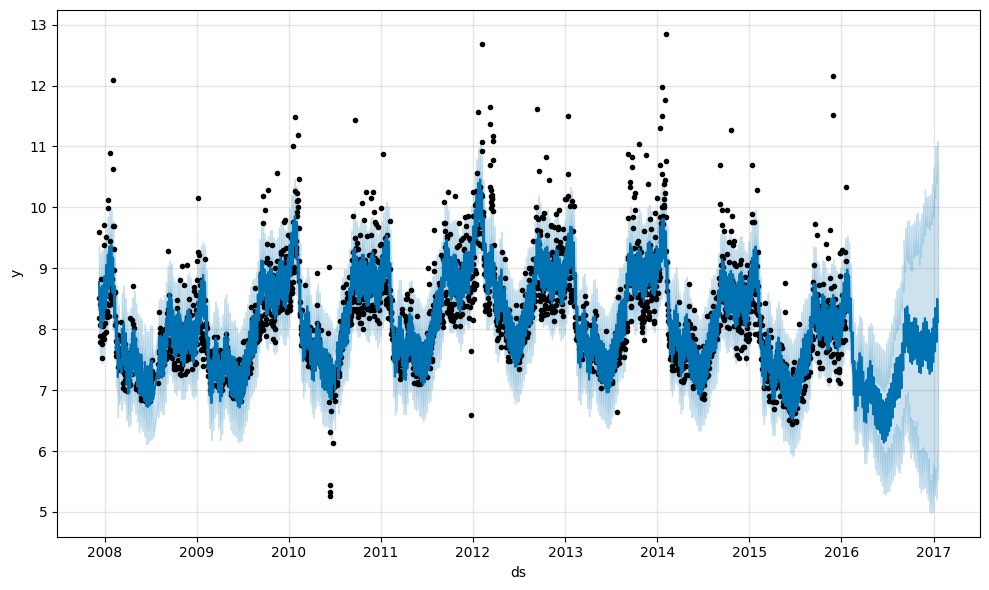

In [12]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing


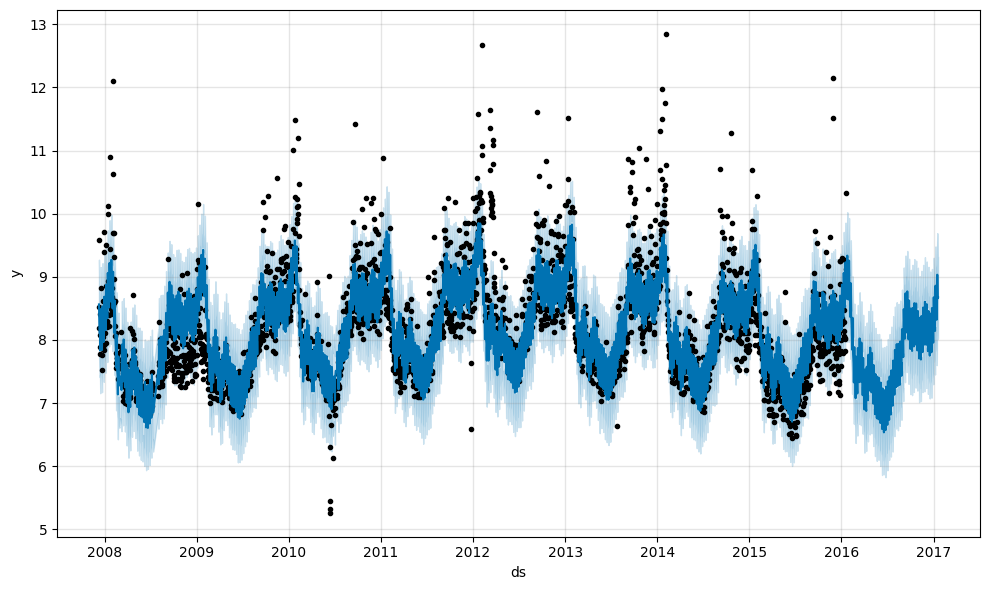

In [13]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

In the second setting we see that the model is more regular.

We can also specify changepoints manually.
```python
m = Prophet(changepoints=['2014-01-01'])
```

## Holidays

We can specify special events that Prophet would take under consideration.

In our dataset we can specify Peyton Manning's playoff appearances.

In [14]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [15]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)


10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

ds   playoff  superbowl
2190 2014-02-02  1.226159   1.201757
2191 2014-02-03  1.904839   1.460264
2532 2015-01-11  1.226159   0.000000
2533 2015-01-12  1.904839   0.000000
2901 2016-01-17  1.226159   0.000000
2902 2016-01-18  1.904839   0.000000
2908 2016-01-24  1.226159   0.000000
2909 2016-01-25  1.904839   0.000000
2922 2016-02-07  1.226159   1.201757
2923 2016-02-08  1.904839   1.460264

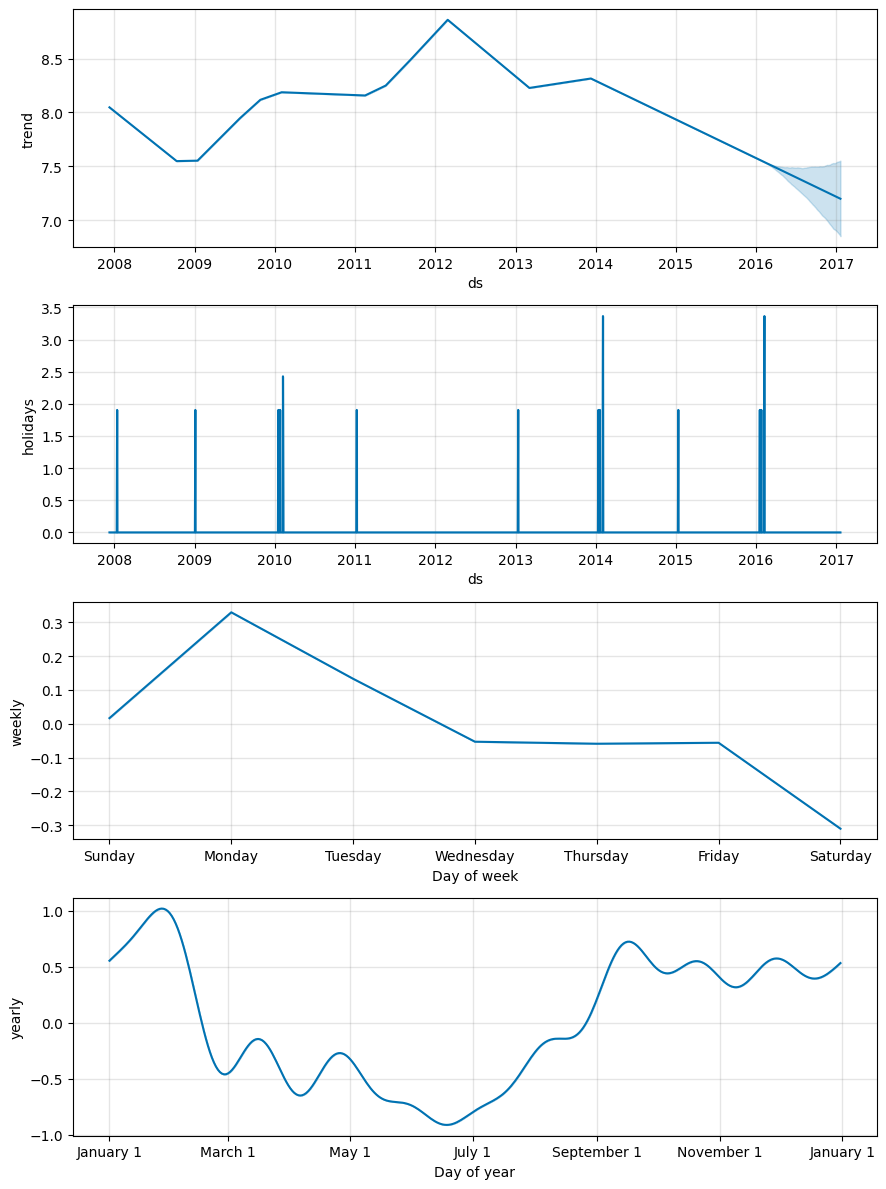

In [17]:
fig = m.plot_components(forecast)

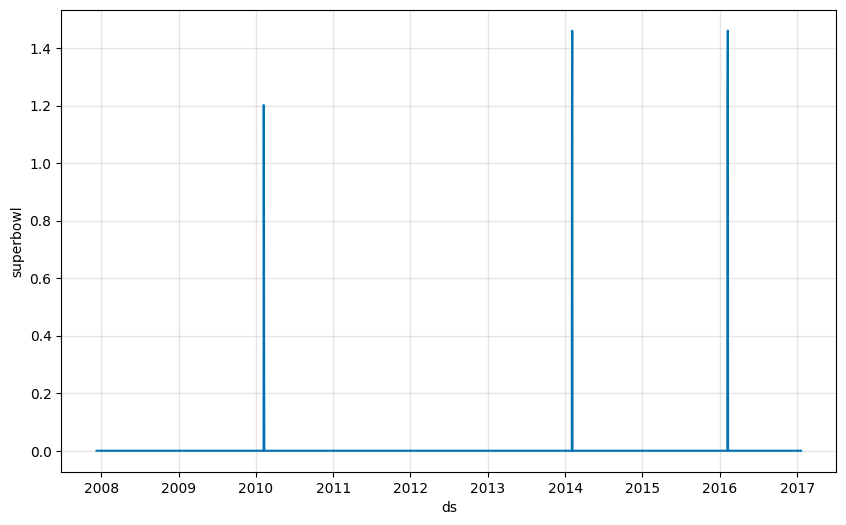

In [18]:
from prophet.plot import plot_forecast_component
plot_forecast_component(m, forecast, 'superbowl')

We can also add country holidays.

In [19]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
m.train_holiday_names


0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

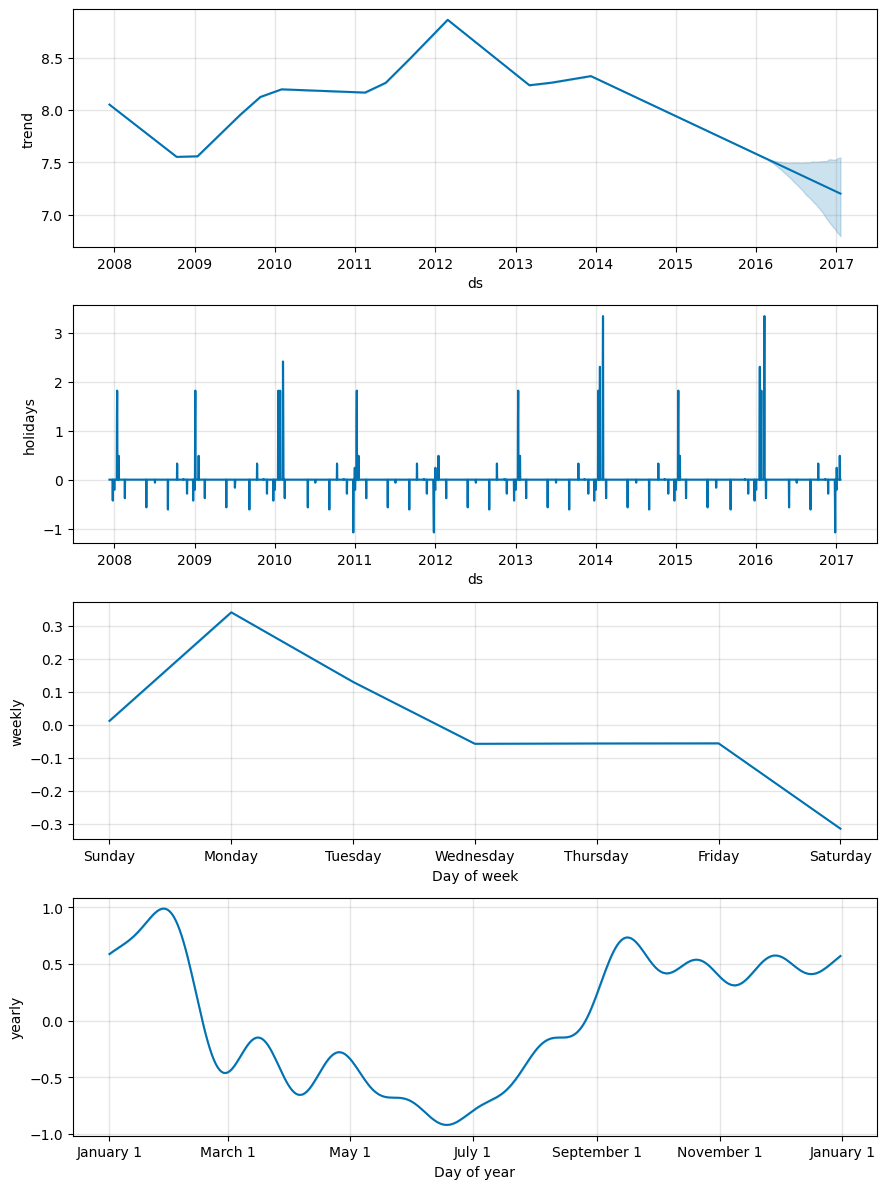

In [21]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

We have holidays for a lot of countries thanks to package https://github.com/dr-prodigy/python-holidays

### Seasonality

Seasonalities are estimated using a partial Fourier sum.
Number of terms in partial sum (order) is parametrizable. 

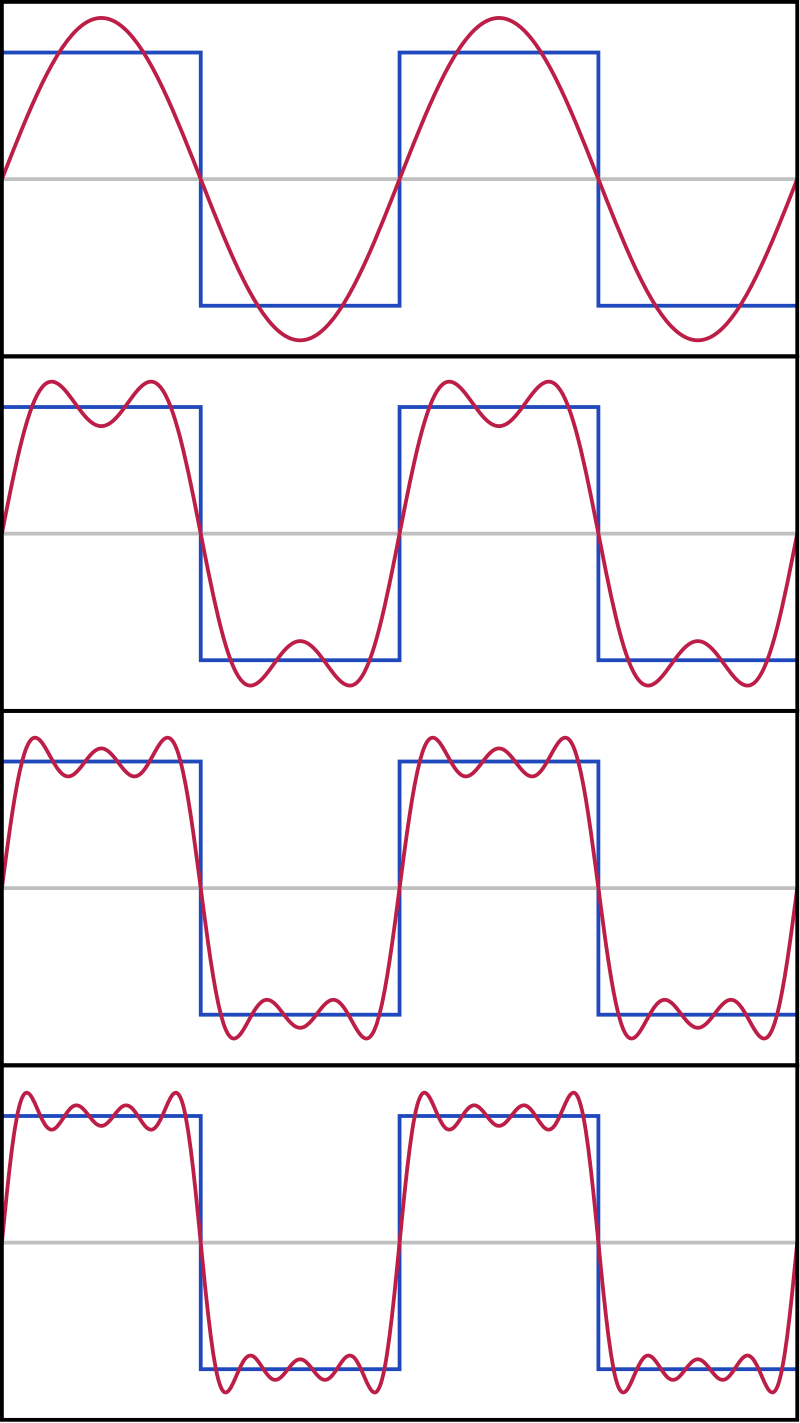

10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing


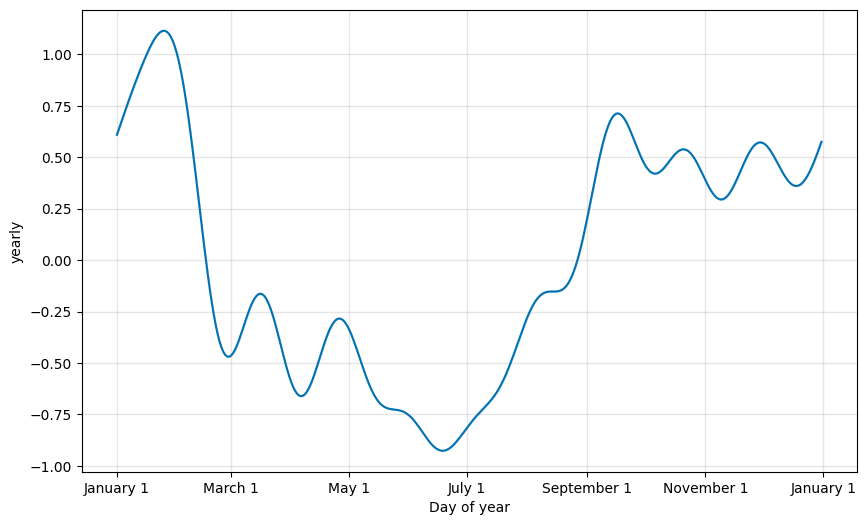

In [22]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing


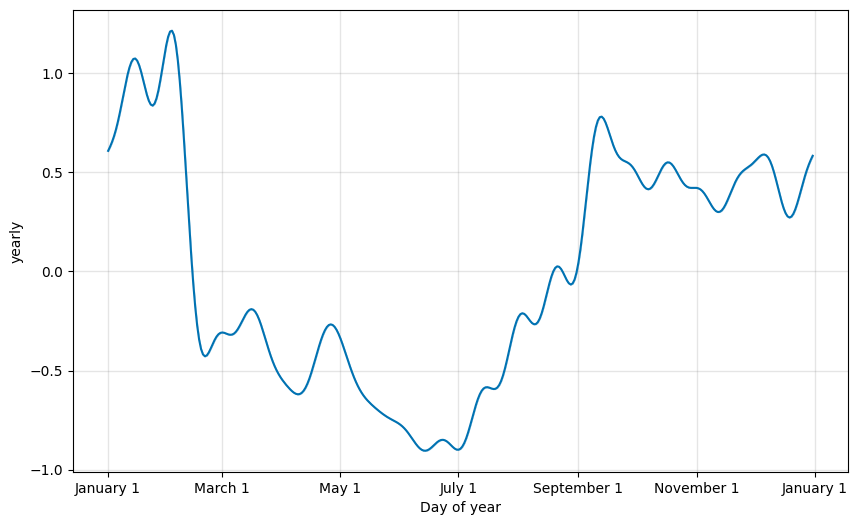

In [23]:
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

### Specifying Custom Seasonalities
Prophet fits weekly and yearly seasonalities by default (for long enough time seires). Other seasonalities can be added with method `add_seasonality`.

10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing


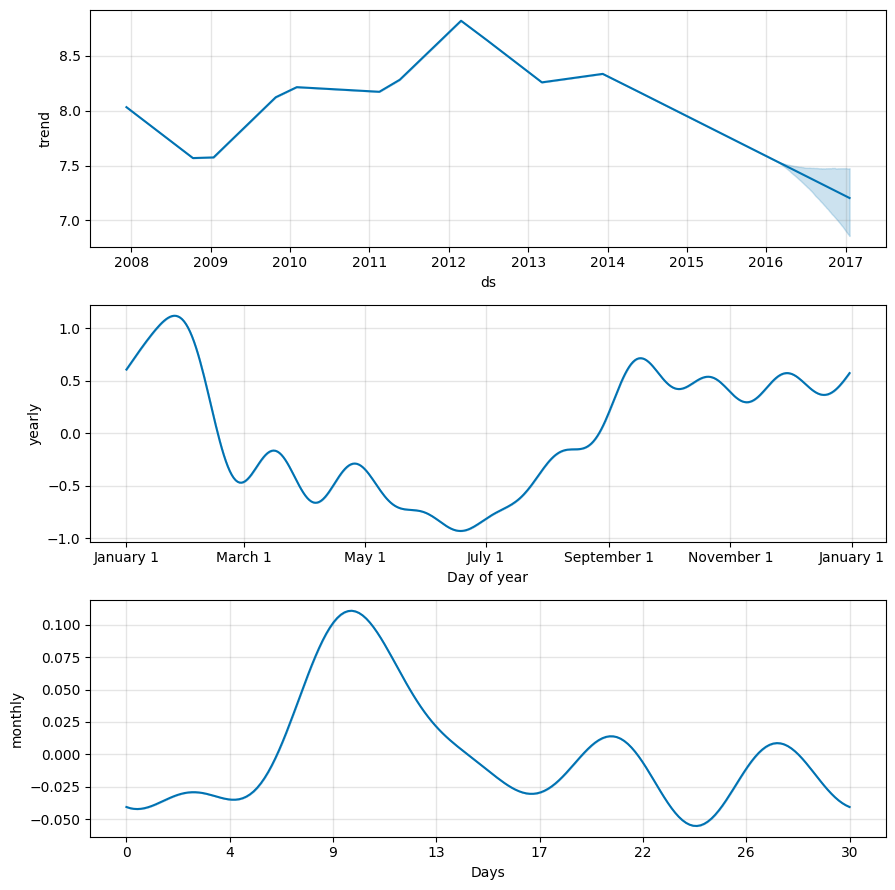

In [24]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

### Conditional seasonality

In our example weekly seasonality is different on- and off-season. Prophet gives us a chance to consider that.

In [25]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)


10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing


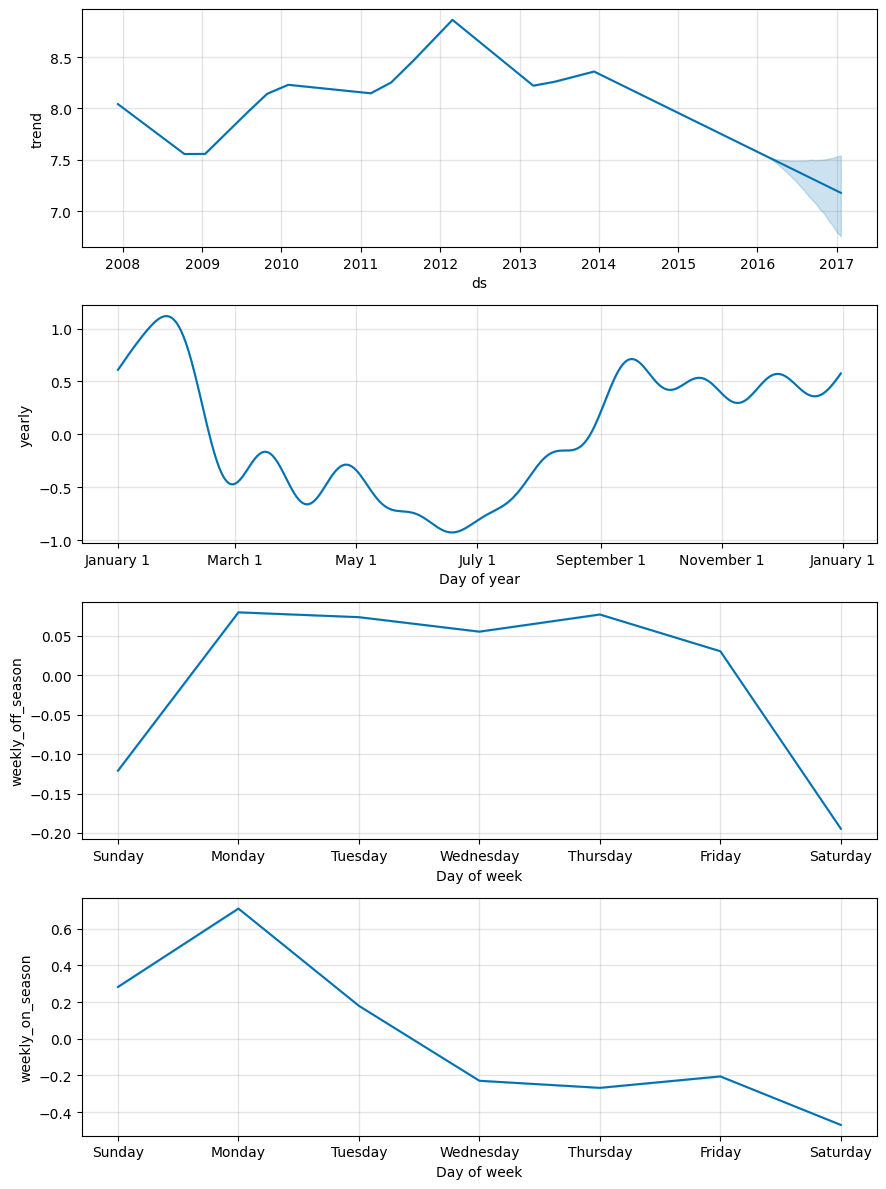

In [26]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

Additionally, we can specify prior scale both to holidays and conditional seasonality

```python
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
```

```
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1
)
```

### Additional regressors

We can add more regressors to our model. They don't have to be binary.

Here is a notebook provided by Facebook how we can add another time series as extra regressor.

https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

## Outliers

10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing


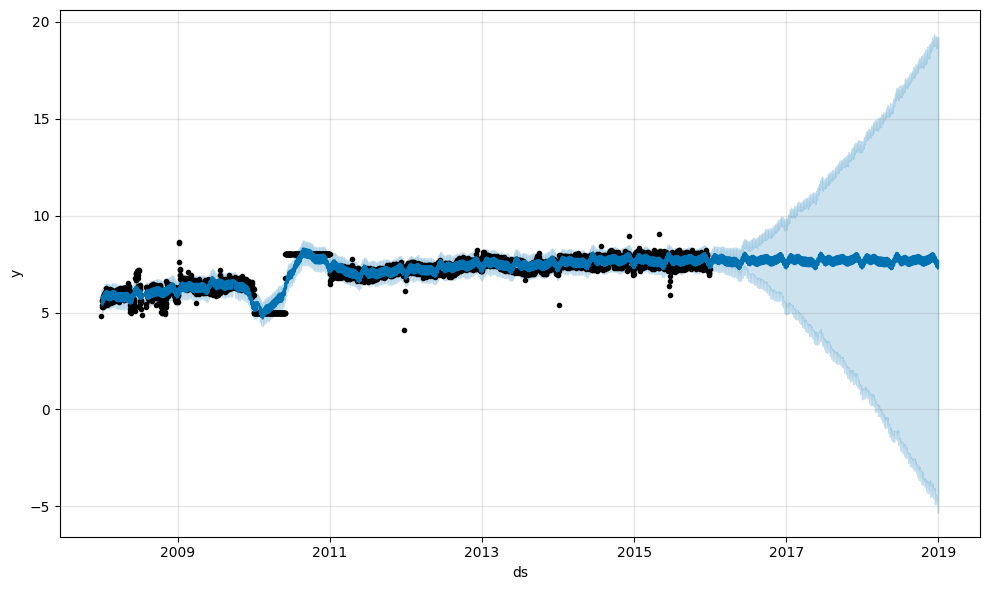

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

Prophter handles the outliers by trend changes but uncertainty model expects changes of similar magnitude. The easiest way to remove outliers in prophet is to remove them.

10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing


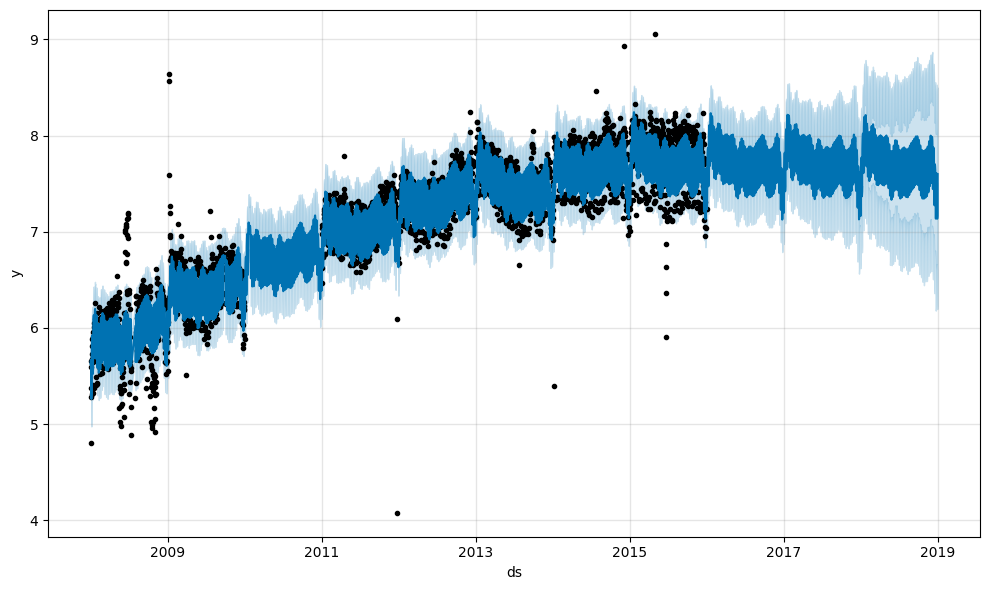

In [28]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

## Diagnostics

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)

10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing


- `horizon` - the time period that we want to get the forecast for
- `initial` - size of the training period
- `period` - spacing between cutoff dates

In [30]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/11 [00:00<?, ?it/s]

10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1]

In [31]:
df_cv.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-02-16  8.957975    8.460547    9.479782  8.242493 2010-02-15
1 2010-02-17  8.724432    8.233279    9.213345  8.008033 2010-02-15
2 2010-02-18  8.608218    8.141419    9.129739  8.045268 2010-02-15
3 2010-02-19  8.530095    7.987016    9.030690  7.928766 2010-02-15
4 2010-02-20  8.272096    7.804433    8.773240  7.745003 2010-02-15

We can specify custom cutoffs.

In [32]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.496346  0.704518  0.507065  0.058775  0.050062  0.059060   
1 38 days  0.502128  0.708610  0.512039  0.059352  0.049743  0.059696   
2 39 days  0.524380  0.724141  0.518133  0.059952  0.049815  0.060422   
3 40 days  0.531642  0.729138  0.521014  0.060260  0.049527  0.060800   
4 41 days  0.539070  0.734214  0.522002  0.060339  0.049743  0.060942   

   coverage  
0  0.679077  
1  0.679077  
2  0.677707  
3  0.681361  
4  0.688899

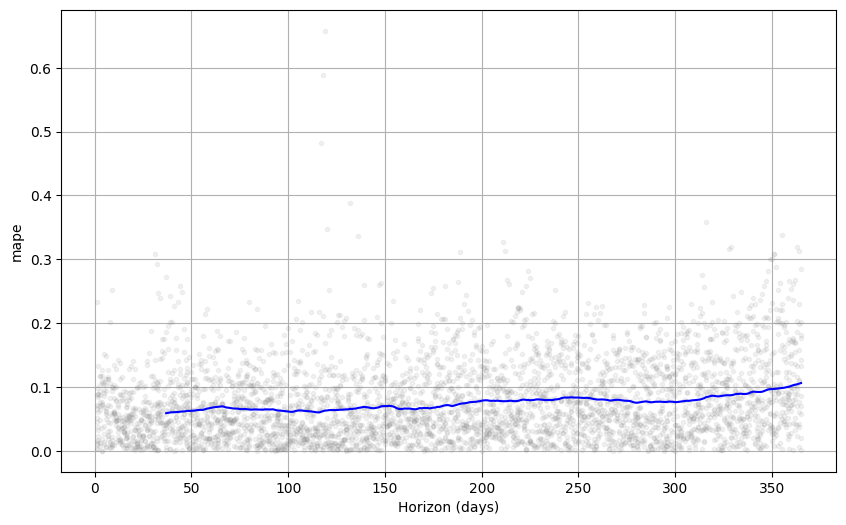

In [34]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


### Hyperparameter tuning

https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

In [35]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.757613
1                     0.001                     0.10  0.750222
2                     0.001                     1.00  0.752932
3                     0.001                    10.00  0.759297
4                     0.010                     0.01  0.545166
5                     0.010                     0.10  0.540289
6                     0.010                     1.00  0.525774
7                     0.010                    10.00  0.524479
8                     0.100                     0.01  0.524566
9                     0.100                     0.10  0.517417
10                    0.100                     1.00  0.517355
11                    0.100                    10.00  0.517853
12                    0.500                     0.01  0.529703
13                    0.500                     0.10  0.524706
14                    0.500                     1.00  0

In [36]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}
